In [1]:
import sys
sys.path.append('..')
from src.kitti import *
import numpy as np
import cv2
import json
import glob
from src.boundingbox import format_yolo_output
from src.trajectory import Trajectory

%matplotlib inline

### Analyzing KITTI sequence 00 image_2

In [2]:
LEFTDIR = '/data/urbinn/datasets/kitti/sequences/00/image_2'
RIGHTDIR = '/data/urbinn/datasets/kitti/sequences/00/image_3'

yolo_data = format_yolo_output("/data/urbinn/darknet/output/seq00_image02/objects.json")
                
frames = []
for filename in sorted(glob.glob(LEFTDIR + '/*')): 
    image_name = filename.split('/')[-1]
    frame = None
    
    if not image_name in yolo_data:
        print("frame {} has no yolo data available".format(image_name))
        frame = Frame(filename, RIGHTDIR)
    else:
        frame = Frame(filename, RIGHTDIR, yolo_data[image_name])
        
    frames.append(frame)

frame 004540.png has no yolo data available


Note: For some reason frame 004540 has no objects detected. This might be possible but requires further investigation.

#### Setting up a sequence

In [3]:
seq = Sequence()
for f in ProgressBar()(frames[:5]):
    seq.add_frame(f)

100% (5 of 5) |###########################| Elapsed Time: 0:00:10 Time: 0:00:10


../src/trajectory.py:28: RuntimeWarning: invalid value encountered in double_scalars
  x = int(self.dimensions[0]) * (p[0] - minx) / (maxxy)
../src/trajectory.py:29: RuntimeWarning: invalid value encountered in double_scalars
  z = int(self.dimensions[0]) - int(self.dimensions[1]) * (p[2] - miny) / (maxxy)


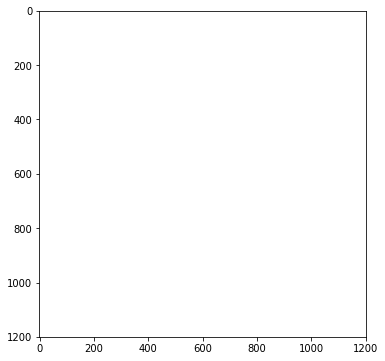

In [4]:
DIMENSION = 400

poses = [kf.get_pose() for kf in seq.keyframes]
trajectory = Trajectory(poses, (1200, 1200))
show(trajectory.draw())

In order to plot the observations it is necessary to convert them to real world coordinates.

In [5]:
def list_classifications_per_keyframe(keyframes):
    """
    Creates a list of classifications found in the span of a keyframe with the observations.
    { 
        [keyframe_id] = {
            [frame_id] = []
            [all (points in all frames within the keyframe)] = []
        }
    }
    """
    keyframe_classification = {}
    
    for index, keyframe in enumerate(keyframes):
        if not index in keyframe_classification:
            keyframe_classification[index] = {}
        
        # Complete list of all points with a classification
        keyframe_classification[index]['all'] = []

        for frame_index, frame in enumerate(keyframe.frames):
            frame.update_observations_per_classification()
            frame.filter_no_classification()
            
            keyframe_classification[index][frame_index] = []
            
            for point in frame.get_observations():
                keyframe_classification[index][frame_index].append(point)
                keyframe_classification[index]['all'].append(point)
                
    return keyframe_classification

In [6]:
classifications_per_keyframe = list_classifications_per_keyframe(seq.keyframes)
classifications_per_keyframe.get(4)

0
['Car', 'Window']


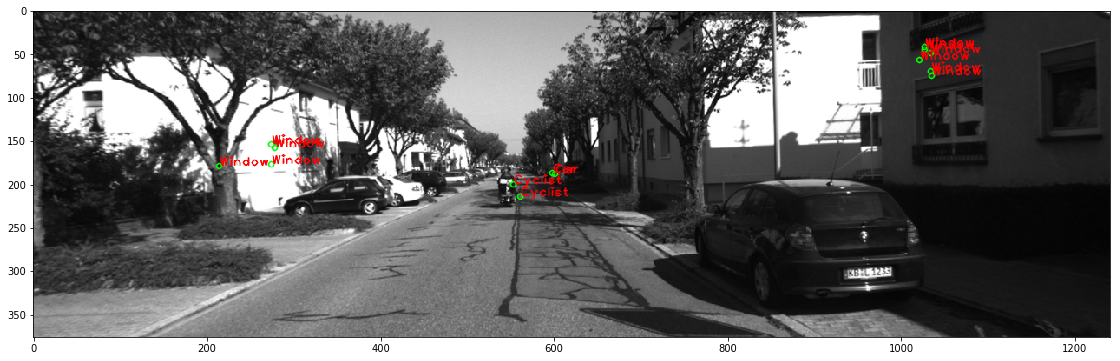

In [7]:
print(seq.keyframes[0].frameid)
seq.keyframes[0].update_observations_per_classification()
seq.keyframes[0].filter_no_classification()

print([box.object_name for box in seq.keyframes[0]._classifications])

points = [obs.get_affine_coords() for obs in seq.keyframes[0].get_observations()]
#points_in_frame = [obs.get_affine_coords() for obs in classifications_per_keyframe.get(0).get(0)]

show(draw_observations_classification(classifications_per_keyframe.get(0).get('all')))

In [8]:
#plt.scatter(x, y, s=area, c=colors, alpha=0.5)